<a href="https://colab.research.google.com/github/ealeongomez/Deep-Learning/blob/master/NND_Cla_Clothes-TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Básicos
import pandas as pd   
import matplotlib.pyplot as plt
import numpy as np

# Artifial Neural Networds (ANN)
import tensorflow as tf
from tensorflow import keras

# Metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
import itertools 
from scipy import interp
import seaborn as sns


In [ ]:
print('Version TensorFlow: ', tf.__version__)
print('Version Keras: ', keras.__version__)

Version TensorFlow:  2.4.1
Version Keras:  2.4.0


#**Functions**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title):   
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='AUC_class_{number} (area={area})'.format(number=i, area=roc_auc["macro"])) 

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")

    plt.show()

#**Fashion MINIST**

1. The data set is divided into training and testing.
2. Because they are images, the values are normalized between 0 and 1, for this it is divided into 255.

In [ ]:
# Load dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print('Training samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print('Validation samples: ', X_valid.shape[0])


Training samples:  55000
Test samples:  10000
Validation samples:  5000


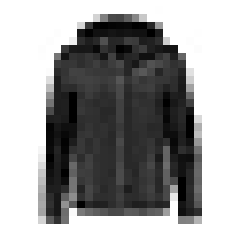

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
print('Labels: ', set(y_train))

Labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

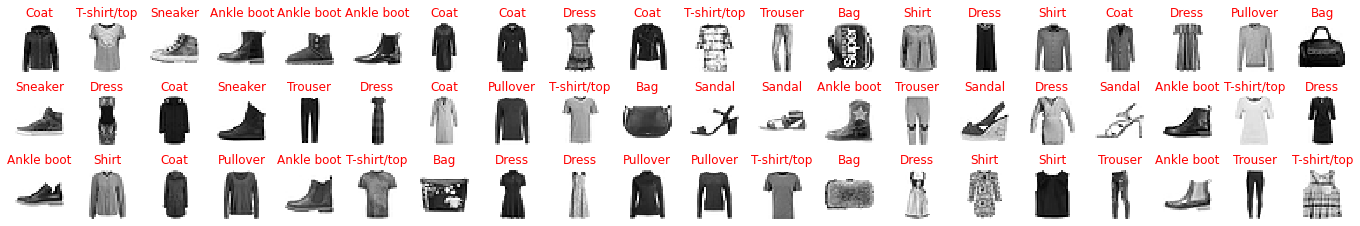

In [ ]:
n_rows = 3
n_cols = 20
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12, c='r')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#**Structuring the Neural Network Artificial (Sequential Version)**

1. Función de activación Sotfmax

$$S(y)_i = \frac{exp(y_i)}{\sum_{j=1}^{n} exp(y_j) }$$

Donde $y$ es el vector de entrada dela función Sotfmax, $y_i$ es el i-ésimo elemento del vector de entrada y $n$ es el número de clases posibles

Ejemplo:

$$S(3.2) = \frac{exp(3.2)}{exp(3.2)+exp(1.3)+exp(0.2)+exp(0.8)}$$



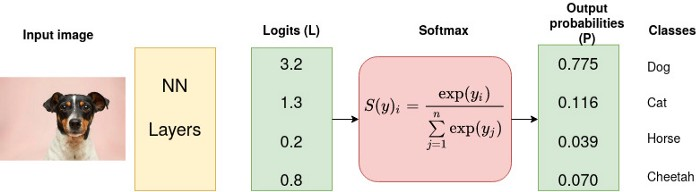

2. Cross-Entropy Loss Function 

- Entropía: se define como el nivel de incertidumbre que presenta una variable $X$ a las posibles variables del resultado

$$ E(x)=\begin{cases} - \int p(x) \: log \: p(x) & \text{si}& X \: es \: continua  
\\ \sum_{x} p(x) \: log \: p(x) & \text{si}& X \: es \: discreta
\end{cases}$$

Un valor mayor de entropía indica una mayor incertidumbre para la distribución de probabilidad, y en el caso anterior, se tendrá una valor de incertidumbre menor

- Binary Cross-Entropy Loss:

$$L = - \sum_{i=1}^{2} t_{i} \: log (p_i) = - \left[ t \: log(p) + (1-t) \: log(1-p) \right]$$

- Definición matematica: 

$$L_{CE} = -\sum_{i=1}^{n} t_{i} \: log \: (P_i)$$

Donde $t_i$ es el valor verdadero de la etiqueta, y $P_i$ es la probabilidad de la función de activación Softmax en la i-ésima clase


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),                 # Input Layer (Para este caso únicamante convitio la matriz en un vector de caraterísticas)
    
    keras.layers.Dense(300, activation="relu",name='Hidden1'),  # Hidden layer 1
    keras.layers.Dense(100, activation="relu",name='Hidden2'),  # Hidden layer 2
    keras.layers.Dense(10, activation="softmax",name='Output')  # Output layer (la cual depende de la aplicación, para este caso son 10 porque es el número de labels)
])

In [ ]:
# Creación de la estrucutura interna de la Red
keras.backend.clear_session()  # Reiniciar todo lo que se ha utilizado 
np.random.seed(42)             # Semillas fijas?     
tf.random.set_seed(42)         # Modelo de inicialización de valores internos de la red neuronal


In [ ]:
# Impresión de la estrucura de la Red Neuronal
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Hidden1 (Dense)              (None, 300)               235500    
_________________________________________________________________
Hidden2 (Dense)              (None, 100)               30100     
_________________________________________________________________
Output (Dense)               (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


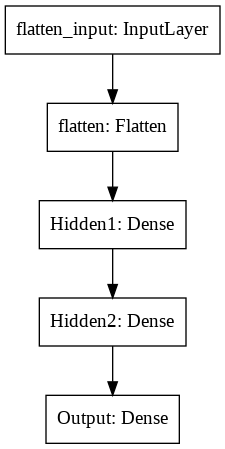

In [ ]:
#keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)
tf.keras.utils.plot_model(model)

**Compilación del modelo**

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",    # Función de costo a derivar
              optimizer="sgd",                           # Optimización: gradiente descendente     
              metrics=["accuracy"])                      # Monitoriar la medida de desempeño (no lo deriva-> solo para ver la tarea final)   

history = model.fit(X_train,                             # Conjunto de entrenamiento
                    y_train,                             # Etiquetas 
                    epochs=30,                           # Epocas: número de veces que se ejecutaran el algoritmo de backpropagation 
                    validation_data=(X_valid, y_valid))  # Conjunto de validación (evaluar el desempeño)

Epoch 1/30
1719/1719 [==============================] - 5s 2ms/step - loss: 1.0234 - accuracy: 0.6734 - val_loss: 0.5291 - val_accuracy: 0.8242
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5132 - accuracy: 0.8204 - val_loss: 0.4422 - val_accuracy: 0.8486
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4564 - accuracy: 0.8403 - val_loss: 0.5093 - val_accuracy: 0.8082
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4264 - accuracy: 0.8518 - val_loss: 0.3979 - val_accuracy: 0.8628
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4129 - accuracy: 0.8569 - val_loss: 0.3815 - val_accuracy: 0.8672
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3817 - accuracy: 0.8648 - val_loss: 0.3746 - val_accuracy: 0.8712
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3714 - accuracy: 0.8694 - val_loss: 0.3692 - val_accuracy:

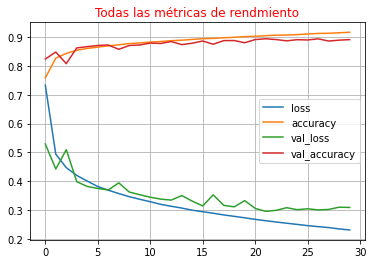

In [ ]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.title('Todas las métricas de rendmiento', c='r')
plt.grid(True)
plt.show()

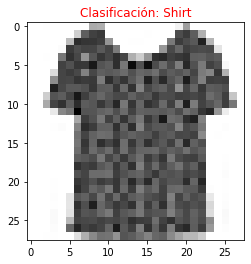

[[0.48 0.   0.04 0.   0.   0.   0.49 0.   0.   0.  ]]


In [ ]:
ii = 1000
pe = model.predict(X_test[ii][np.newaxis,:,:])

probabilidad = 'Clasificación: ' + class_names[np.argmax(pe.round(2))]
plt.title(probabilidad, c='r')
plt.imshow(X_test[ii],cmap='binary',vmin=0,vmax=1)
plt.show()

print(pe.round(2))


#**How good is your model?**


## 1. **Confusion matriz** 

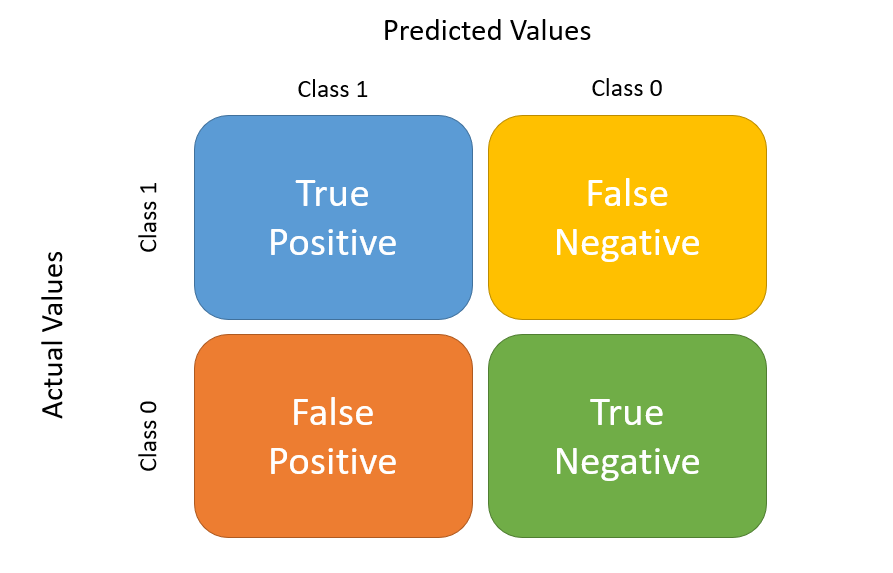

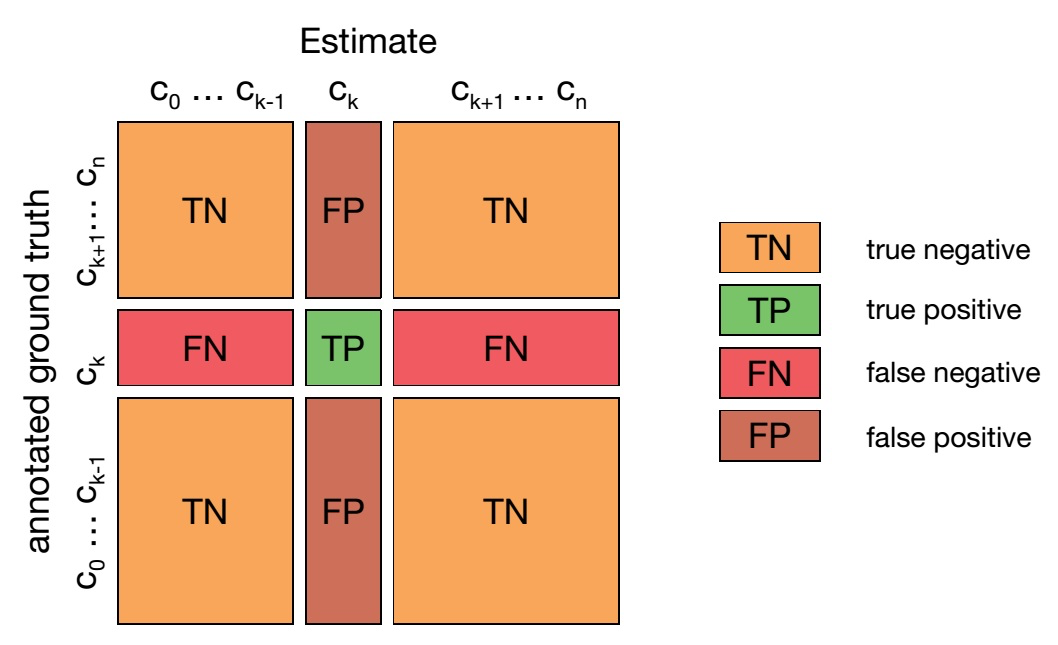

In [ ]:
pred_ = np.round(model.predict(X_test))
pred_NN = np.array([x.argmax() for x in pred_])

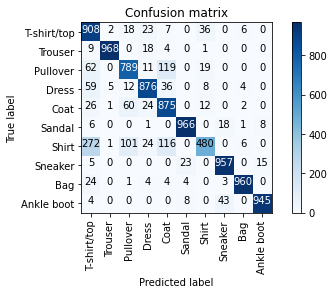

In [ ]:
plot_confusion_matrix(confusion_matrix(list(y_test), list(pred_NN)),  classes = class_names)

## 2. **Report**

- ERR y Acucuracy: información general sobre el error de classificación de las muestras 

  $$ERR = \frac{f_p+f_n}{f_p+f_n+t_p+t_n}$$

  $$ACC = \frac{t_p+t_n}{f_p+f_n+t_p+t_n} = 1-ERR$$

- Precision (Exactitud): 

  $$\frac{t_p}{t_p+f_p}$$

- Recall (Exhaustividad):

  $$\frac{t_p}{t_p+f_n}$$

- F1 Score: 

  $$2 \frac{Precision . Recall}{Precision + Recall}$$


In [ ]:
print(classification_report(y_test, pred_NN, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.66      0.91      0.76      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.80      0.79      0.80      1000
       Dress       0.89      0.88      0.88      1000
        Coat       0.75      0.88      0.81      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.86      0.48      0.62      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



##3. Curve ROC

*Receiver Operating Characteristic*

Esta métrica es muy útila para la selección de modelos de clasificación basados en el redimiento de su *Precision* y *Recall*. Esta curva traza la tasa de verdaderos positivos frente a la tasa de falsos positivos 

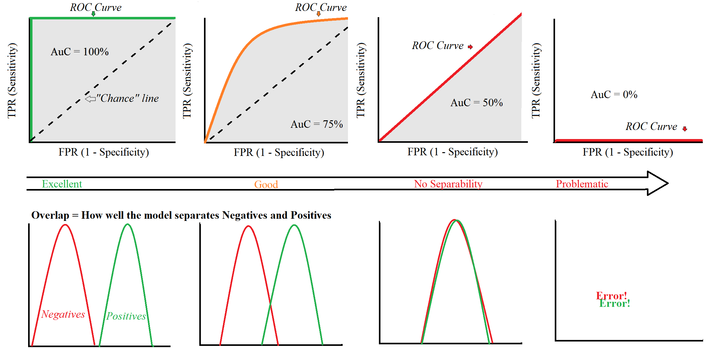

In [ ]:
ytest_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[0]

for i in range(len(class_names)):
  fpr[i], tpr[i], _ = roc_curve(pred_[:, i], ytest_score[:, i])
fpr["micro"], tpr["micro"], _ = roc_curve(pred_.ravel(), ytest_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


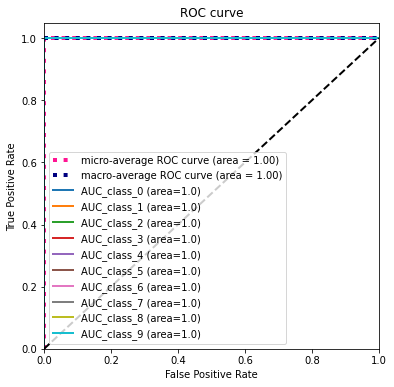

In [ ]:
roc_auc_mc(roc_auc,fpr,tpr, len(class_names), 'ROC curve')